In [2]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm
from collections import OrderedDict, Counter
import copy

/home/pili/anaconda3/envs/scia/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/home/pili/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 1040.51it/s]
Loading cached split indices for dataset at /home/pili/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /home/pili/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

In [4]:
min_freq = 5
tokenizer = get_tokenizer("basic_english", language="en")

tokens = []
unk_token = "<unk>"
pad_token = "<pad>"
for text in tqdm(train_df['text'], total=len(train_df)):
    tokens += tokenizer(text)
vocabulary = vocab(OrderedDict(sorted(Counter(tokens).items(), key=lambda x: x[1], reverse=True)), min_freq=min_freq, specials=[pad_token, unk_token])
vocabulary.set_default_index(vocabulary[unk_token])

100%|██████████| 20000/20000 [00:01<00:00, 16518.54it/s]


In [5]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor(
        [vocabulary[token] for token in tokenizer(text)], dtype=torch.long
    )

text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

100%|██████████| 25000/25000 [00:03<00:00, 6942.78it/s]


In [6]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    n_samples = len(X)
    n_batches = n_samples // batch_size
    for i in range(n_batches):
        X_batch = X[i * batch_size : (i + 1) * batch_size]
        y_batch = y[i * batch_size : (i + 1) * batch_size]
        max_len = max([len(x) for x in X_batch])
        #print(max_len)
        #print(X_batch[0])
        X_batch = torch.stack(
            [torch.cat((torch.tensor([pad_id] * (max_len - len(x)), dtype=int), x)) for x in X_batch],
        )
        yield X_batch, torch.tensor(y_batch, dtype=torch.int)

train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

print(next(train_gen()))

(tensor([[   0,    0,    0,  ...,   57,   35,    3],
        [   0,    0,    0,  ...,    1,    9,    3],
        [   0,    0,    0,  ...,  131,  180,    3],
        ...,
        [   0,    0,    0,  ...,   34, 1525,    3],
        [   0,    0,    0,  ...,   14,   21,    3],
        [   0,    0,    0,  ...,   14,   23,   36]]), tensor([1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1], dtype=torch.int32))


In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Using pyTorch implementation

In this second part, we use pyTorch's implementation of RNNs and LSTMs. Again, as we are focusing on understanding the model and library, we will keep using the IMDB dataset. The good news is training is much faster using pyTorch's implementations.

## From dataset to batch inputs

You already know what to do here, it's the same as in the previous notebook.

## The classifier

The implementation behind shows how to use the [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) implementation provided by pyTorch to code a simple RNN.

In [8]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

In [9]:
# compute accuracy
def accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    """
    Compute the accuracy of a model.
    Args:
        y_pred: the predictions of the model.
        y_true: the true labels.
    Returns:
        The accuracy of the model.
    """
    with torch.no_grad():
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        return (y_pred == y_true).sum().item() / len(y_true)


## Training (1 point)

**\[1 point\]** Code the training function.
* Note that we are using a function, as we will use it on several models here.
* The RNN implementation of pyTorch doesn't need to be manually looped. As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.

In [10]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    Returns:
        A tuple:[best_model (by validation loss), training losses, validation losses].
    """
    return_train_loss = []
    return_valid_loss = []
    best_model = None
    best_valid_loss = np.inf

    for epochs in range(n_epochs):
        model.train()
        train_loss_l = []
        train_acc_l = []
        for X_batch, y_batch in tqdm(train_gen()):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze().float(), y_batch.float())
            loss.backward()
            optimizer.step()
            train_loss_l.append(loss.item())
            train_acc_l.append(accuracy(y_pred.squeeze().float(), y_batch.float()))
        train_loss = np.mean(train_loss_l)
        train_acc = np.mean(train_acc_l)

        print(f"Epoch {epochs}/{n_epochs}")
        print(f"Train loss: {train_loss:.2E}, Train acc: {train_acc}")

        model.eval()
        valid_loss_l = []
        valid_acc_l = []
        with torch.no_grad():
            for X_batch, y_batch in tqdm(valid_gen()):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred.squeeze().float(), y_batch.float())
                valid_loss_l.append(loss.item())
                valid_acc_l.append(accuracy(y_pred.squeeze().float(), y_batch.float()))
            valid_loss = np.mean(valid_loss_l)
            valid_acc = np.mean(valid_acc_l)

        print(f"Valid loss: {valid_loss:.2E}, Valid acc: {valid_acc}")

        return_train_loss.append(train_loss)
        return_valid_loss.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
        
    return best_model, return_train_loss, return_valid_loss

In [11]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [12]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

625it [00:03, 173.62it/s]


Epoch 0/20
Train loss: 6.75E-01, Train acc: 0.5685


156it [00:00, 396.96it/s]


Valid loss: 6.78E-01, Valid acc: 0.546875


625it [00:03, 187.06it/s]


Epoch 1/20
Train loss: 6.60E-01, Train acc: 0.596


156it [00:00, 457.08it/s]


Valid loss: 6.25E-01, Valid acc: 0.6510416666666666


625it [00:03, 188.17it/s]


Epoch 2/20
Train loss: 6.04E-01, Train acc: 0.6748


156it [00:00, 453.36it/s]


Valid loss: 6.58E-01, Valid acc: 0.6115785256410257


625it [00:03, 185.85it/s]


Epoch 3/20
Train loss: 6.35E-01, Train acc: 0.6309


156it [00:00, 442.75it/s]


Valid loss: 6.44E-01, Valid acc: 0.6270032051282052


625it [00:03, 179.74it/s]


Epoch 4/20
Train loss: 6.02E-01, Train acc: 0.67735


156it [00:00, 422.92it/s]


Valid loss: 6.28E-01, Valid acc: 0.6370192307692307


625it [00:03, 177.42it/s]


Epoch 5/20
Train loss: 5.39E-01, Train acc: 0.7325


156it [00:00, 439.67it/s]


Valid loss: 6.32E-01, Valid acc: 0.6312099358974359


625it [00:03, 178.84it/s]


Epoch 6/20
Train loss: 5.41E-01, Train acc: 0.7306


156it [00:00, 450.00it/s]


Valid loss: 5.60E-01, Valid acc: 0.7227564102564102


625it [00:03, 184.33it/s]


Epoch 7/20
Train loss: 4.90E-01, Train acc: 0.7703


156it [00:00, 463.76it/s]


Valid loss: 5.48E-01, Valid acc: 0.7333733974358975


625it [00:03, 185.90it/s]


Epoch 8/20
Train loss: 4.91E-01, Train acc: 0.76615


156it [00:00, 435.93it/s]


Valid loss: 5.71E-01, Valid acc: 0.719551282051282


625it [00:03, 188.52it/s]


Epoch 9/20
Train loss: 4.27E-01, Train acc: 0.813


156it [00:00, 449.48it/s]


Valid loss: 5.37E-01, Valid acc: 0.7471955128205128


625it [00:03, 188.59it/s]


Epoch 10/20
Train loss: 5.81E-01, Train acc: 0.68995


156it [00:00, 459.78it/s]


Valid loss: 6.41E-01, Valid acc: 0.616386217948718


625it [00:03, 185.16it/s]


Epoch 11/20
Train loss: 5.67E-01, Train acc: 0.6957


156it [00:00, 431.94it/s]


Valid loss: 6.40E-01, Valid acc: 0.6272035256410257


625it [00:03, 187.81it/s]


Epoch 12/20
Train loss: 5.21E-01, Train acc: 0.73015


156it [00:00, 457.65it/s]


Valid loss: 6.33E-01, Valid acc: 0.6538461538461539


625it [00:03, 187.62it/s]


Epoch 13/20
Train loss: 4.35E-01, Train acc: 0.79875


156it [00:00, 450.88it/s]


Valid loss: 5.96E-01, Valid acc: 0.7029246794871795


625it [00:03, 190.16it/s]


Epoch 14/20
Train loss: 3.86E-01, Train acc: 0.8311


156it [00:00, 442.69it/s]


Valid loss: 5.99E-01, Valid acc: 0.7309695512820513


625it [00:03, 184.27it/s]


Epoch 15/20
Train loss: 3.78E-01, Train acc: 0.83925


156it [00:00, 440.75it/s]


Valid loss: 5.74E-01, Valid acc: 0.7401842948717948


625it [00:03, 191.65it/s]


Epoch 16/20
Train loss: 3.56E-01, Train acc: 0.8505


156it [00:00, 441.90it/s]


Valid loss: 6.02E-01, Valid acc: 0.741386217948718


625it [00:03, 191.63it/s]


Epoch 17/20
Train loss: 3.29E-01, Train acc: 0.86635


156it [00:00, 446.87it/s]


Valid loss: 5.90E-01, Valid acc: 0.7520032051282052


625it [00:03, 189.63it/s]


Epoch 18/20
Train loss: 3.31E-01, Train acc: 0.86125


156it [00:00, 421.01it/s]


Valid loss: 6.14E-01, Valid acc: 0.7121394230769231


625it [00:03, 182.53it/s]


Epoch 19/20
Train loss: 3.33E-01, Train acc: 0.8641


156it [00:00, 450.09it/s]

Valid loss: 6.04E-01, Valid acc: 0.7317708333333334


[0.6746922749519348, 0.659805302810669, 0.6035137592315674, 0.6351169561386109, 0.6017607233524322, 0.5386327493190766, 0.5405696112155914, 0.4896705947637558, 0.4912942199230194, 0.42659829688072204, 0.5810817044973373, 0.5668634547710418, 0.5213850821495056, 0.4350346660375595, 0.38557295565605165, 0.3781465077638626, 0.356183175265789, 0.32939154233932494, 0.33125761383771896, 0.3331722538113594]


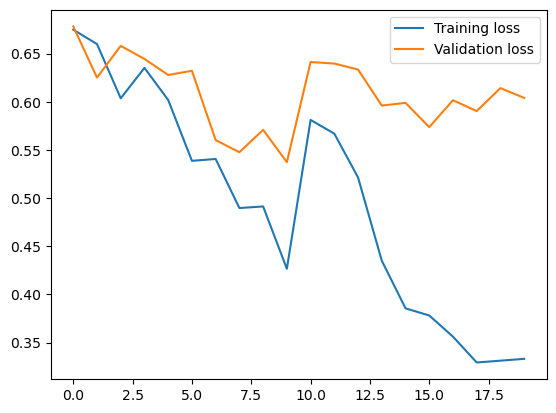

In [13]:
import matplotlib.pyplot as plt
print(train_losses)
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

## Do the following (5 points)
* **\[1 point\]** Add an accuracy function and report the accuracy of the training, validation, and test set.
* **\[2 points\]** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
  * Look at the [LSTM documentation of pyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
* **\[1 point\]** Implement a function which takes any text and returns the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).
* **\[Bonus\]** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * **Beware of the behaviour of the output layer.** For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.
* **\[1 point\]** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **\[Bonus\]** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

In [14]:
# print the test, train and validation accuracy
def test(model: nn.Module, test_gen: Callable) -> float:
    """Test a model.
    Args:
        model: a class inheriting from nn.Module.
        test_gen: a callable function returing a batch (data, labels).
    Returns:
        The accuracy of the model.
    """
    model.eval()
    test_acc_l = []
    with torch.no_grad():
        for X_batch, y_batch in test_gen():
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            test_acc_l.append(accuracy(y_pred.squeeze().float(), y_batch.float()))
        test_acc = np.mean(test_acc_l)
    return test_acc

print(f"Test accuracy: {test(best_model, test_gen)}")
print(f"Train accuracy: {test(best_model, train_gen)}")
print(f"Valid accuracy: {test(best_model, valid_gen)}")

/home/pili/anaconda3/envs/scia/lib/python3.11/site-packages/torch/nn/modules/rnn.py:509: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,


Test accuracy: 0.7470790653008963
Train accuracy: 0.84125
Valid accuracy: 0.7471955128205128


In [15]:
# class lstm
class LSTM(nn.Module):
    """A simple LSTM module with word embeddings."""

    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The LSTM
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the LSTM's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.lstm(out, (h0, c0))
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out
    

In [16]:
LSTM_model = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)
LSTM_criterion = nn.BCEWithLogitsLoss()
LSTM_optimizer = torch.optim.Adam(LSTM_model.parameters())

In [17]:
LSTM_best_model, LSTM_train_losses, LSTM_valid_losses = train(LSTM_model, LSTM_criterion, LSTM_optimizer, 20, train_gen, valid_gen)

625it [00:03, 176.06it/s]


Epoch 0/20
Train loss: 6.55E-01, Train acc: 0.6047


156it [00:00, 374.99it/s]


Valid loss: 5.92E-01, Valid acc: 0.6838942307692307


625it [00:03, 174.21it/s]


Epoch 1/20
Train loss: 5.78E-01, Train acc: 0.7051


156it [00:00, 364.96it/s]


Valid loss: 6.52E-01, Valid acc: 0.602363782051282


625it [00:03, 175.08it/s]


Epoch 2/20
Train loss: 4.87E-01, Train acc: 0.7654


156it [00:00, 362.78it/s]


Valid loss: 4.45E-01, Valid acc: 0.8002804487179487


625it [00:03, 172.43it/s]


Epoch 3/20
Train loss: 3.71E-01, Train acc: 0.8431


156it [00:00, 373.09it/s]


Valid loss: 5.33E-01, Valid acc: 0.7622195512820513


625it [00:03, 174.23it/s]


Epoch 4/20
Train loss: 4.77E-01, Train acc: 0.7763


156it [00:00, 361.61it/s]


Valid loss: 5.81E-01, Valid acc: 0.6822916666666666


625it [00:03, 175.35it/s]


Epoch 5/20
Train loss: 3.50E-01, Train acc: 0.85005


156it [00:00, 369.94it/s]


Valid loss: 4.16E-01, Valid acc: 0.8155048076923077


625it [00:03, 176.17it/s]


Epoch 6/20
Train loss: 2.54E-01, Train acc: 0.9029


156it [00:00, 372.04it/s]


Valid loss: 3.69E-01, Valid acc: 0.8473557692307693


625it [00:03, 175.89it/s]


Epoch 7/20
Train loss: 2.02E-01, Train acc: 0.9267


156it [00:00, 366.45it/s]


Valid loss: 3.55E-01, Valid acc: 0.8521634615384616


625it [00:03, 177.87it/s]


Epoch 8/20
Train loss: 1.66E-01, Train acc: 0.94195


156it [00:00, 378.79it/s]


Valid loss: 3.76E-01, Valid acc: 0.8533653846153846


625it [00:03, 176.43it/s]


Epoch 9/20
Train loss: 1.43E-01, Train acc: 0.9518


156it [00:00, 372.75it/s]


Valid loss: 4.00E-01, Valid acc: 0.8513621794871795


625it [00:03, 175.94it/s]


Epoch 10/20
Train loss: 1.18E-01, Train acc: 0.961


156it [00:00, 366.43it/s]


Valid loss: 4.15E-01, Valid acc: 0.8385416666666666


625it [00:03, 171.94it/s]


Epoch 11/20
Train loss: 1.03E-01, Train acc: 0.9674


156it [00:00, 360.31it/s]


Valid loss: 4.31E-01, Valid acc: 0.8461538461538461


625it [00:03, 162.50it/s]


Epoch 12/20
Train loss: 9.39E-02, Train acc: 0.96995


156it [00:00, 361.33it/s]


Valid loss: 4.19E-01, Valid acc: 0.8565705128205128


625it [00:03, 173.09it/s]


Epoch 13/20
Train loss: 7.53E-02, Train acc: 0.9758


156it [00:00, 364.35it/s]


Valid loss: 4.51E-01, Valid acc: 0.8605769230769231


625it [00:03, 173.92it/s]


Epoch 14/20
Train loss: 5.80E-02, Train acc: 0.9834


156it [00:00, 361.84it/s]


Valid loss: 4.75E-01, Valid acc: 0.8495592948717948


625it [00:03, 170.69it/s]


Epoch 15/20
Train loss: 4.87E-02, Train acc: 0.9856


156it [00:00, 373.20it/s]


Valid loss: 4.79E-01, Valid acc: 0.8393429487179487


625it [00:03, 169.86it/s]


Epoch 16/20
Train loss: 4.23E-02, Train acc: 0.98815


156it [00:00, 376.42it/s]


Valid loss: 5.55E-01, Valid acc: 0.8323317307692307


625it [00:03, 173.86it/s]


Epoch 17/20
Train loss: 3.18E-02, Train acc: 0.9917


156it [00:00, 358.63it/s]


Valid loss: 6.78E-01, Valid acc: 0.8381410256410257


625it [00:03, 172.14it/s]


Epoch 18/20
Train loss: 2.61E-02, Train acc: 0.9932


156it [00:00, 355.50it/s]


Valid loss: 7.86E-01, Valid acc: 0.835136217948718


625it [00:03, 168.14it/s]


Epoch 19/20
Train loss: 2.06E-02, Train acc: 0.9946


156it [00:00, 366.64it/s]

Valid loss: 6.84E-01, Valid acc: 0.8685897435897436


[0.6549803654193879, 0.5778628606796264, 0.48690061790943145, 0.3710882281541824, 0.4765769584655762, 0.3495230974316597, 0.2540851557135582, 0.20201683142781257, 0.1660393936306238, 0.14298461384177208, 0.11836209798008203, 0.10346118331849576, 0.09387917255610227, 0.07530723089575768, 0.05800960860997439, 0.04871521101370454, 0.04226485201809555, 0.03176722419280559, 0.026131245116889478, 0.02060534490304999]


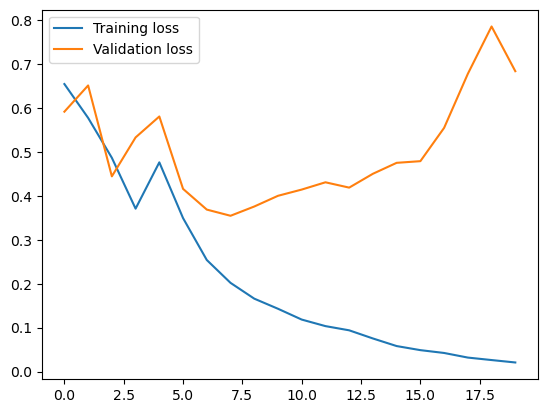

In [18]:
print(LSTM_train_losses)
plt.plot(LSTM_train_losses, label="Training loss")
plt.plot(LSTM_valid_losses, label="Validation loss")
plt.legend()
plt.show()

In [19]:
print(f"Test accuracy: {test(LSTM_best_model, test_gen)}")
print(f"Train accuracy: {test(LSTM_best_model, train_gen)}")
print(f"Valid accuracy: {test(LSTM_best_model, valid_gen)}")

/home/pili/anaconda3/envs/scia/lib/python3.11/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Test accuracy: 0.8591949423815621
Train accuracy: 0.9439
Valid accuracy: 0.8521634615384616


In [32]:
# compare the two models
# off warning
import warnings
warnings.filterwarnings("ignore")
print(f"RNN Test accuracy: {test(best_model, test_gen)}")
print(f"LSTM Test accuracy: {test(LSTM_best_model, test_gen)}")
print("")

print(f"RNN Train accuracy: {test(best_model, train_gen)}")
print(f"LSTM Train accuracy: {test(LSTM_best_model, train_gen)}")
print("")

print(f"RNN Valid accuracy: {test(best_model, valid_gen)}")
print(f"LSTM Valid accuracy: {test(LSTM_best_model, valid_gen)}")


RNN Test accuracy: 0.7470790653008963
LSTM Test accuracy: 0.8591949423815621

RNN Train accuracy: 0.84125
LSTM Train accuracy: 0.9439

RNN Valid accuracy: 0.7471955128205128
LSTM Valid accuracy: 0.8521634615384616


Both models seems to overfit the data, LSTM does a way stronger overfit after a lot of epochs.

But overall LSTM has a better validation accuracy on it's best model

In [33]:
def predict(text, model):
    model.eval()
    with torch.no_grad():
        text = text_pipeline(text).unsqueeze(0).to(device)
        y_pred = model(text)
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        return y_pred.item()
    
str = "This movie is bad"
print("RNN : ", str , predict(str, best_model))
print("LSTM : ", str , predict(str, LSTM_best_model))

str = "This movie is good"
print("RNN : ", str , predict(str, best_model))
print("LSTM : ", str , predict(str, LSTM_best_model))

str = "This movie is not bad"
print("RNN : ", str , predict(str, best_model))
print("LSTM : ", str , predict(str, LSTM_best_model))

RNN :  This movie is bad 0.0
LSTM :  This movie is bad 0.0
RNN :  This movie is good 0.0
LSTM :  This movie is good 1.0
RNN :  This movie is not bad 0.0
LSTM :  This movie is not bad 0.0


In [35]:
# with the best model
# manually print two wrong predictions from the test set
    
def print_wrong_prediction(model, nb=2):
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_gen():
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            y_pred = torch.sigmoid(y_pred)
            y_pred = torch.round(y_pred)
            for i in range(len(y_pred)):
                if y_pred[i] != y_batch[i]:
                    print("Predicted : ", y_pred[i].item(), "Actual : ", y_batch[i].item())
                    print("Text : ", test_df["text"][i])
                    print("")
                    nb -= 1
                    if nb == 0:
                        return

print_wrong_prediction(best_model)

Predicted :  1.0 Actual :  0
Text :  STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning <br /><br />Former New Orleans homicide cop Jack Robideaux (Jean Claude Van Damme) is re-assigned to Columbus, a small but violent town in Mexico to help the police there with their efforts to stop a major heroin smuggling operation into their town. The culprits turn out to be ex-military, lead by former commander Benjamin Meyers (Stephen Lord, otherwise known as Jase from East Enders) who is using a special method he learned in Afghanistan to fight off his opponents. But Jack has a more personal reason for taking him down, that draws the two men into an explosive final showdown where only one will walk away alive.<br /><br />After Until Death, Van Damme appeared to be on a high, showing he could make the best straight to video films in the action market. While that was a far more drama oriented film, with The Shepherd he has returned to the high-

# TODO : expliquer les mauvais examples